In [2]:
import numpy as np
import matplotlib.pyplot as plt

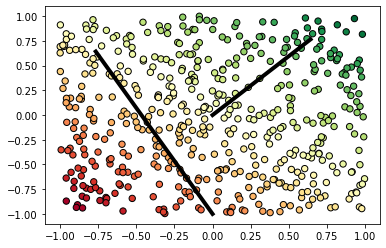

In [35]:
n = 500
U = np.random.uniform(-1,1,(2,n))
theta = 50
direction = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
direction_normal = np.array([np.cos(np.radians(theta+90)), np.sin(np.radians(theta+90))])
colors = [np.dot(U[:,i], direction) for i in range(n)]
plt.scatter(U[0,:], U[1,:], c=colors, cmap="RdYlGn", s=40, edgecolors="black");
plt.plot([0,direction[0]], [0, direction[1]], "k", linewidth=4)
plt.plot([0,direction_normal[0]], [0-1, direction_normal[1]], "k", linewidth=4)

plt.show()